# DynamicEndpoint Snitch Measurement Choices

Historically the DES has used a Median Filter approximated with a Codahale ExpononentiallyDecayingReservoir with a memory of about 100 items. There are proposals that we should change this ranking filter, for example to an Exponential Moving Average. This notebook is my attempt to model Cassandra replica latencies using probability distributions taking into account the frequent causes of latency (e.g. disks, safepoints, networks, and timeouts) and figure out which filter is appropriate.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy
import scipy.stats

scipy.random.seed(1234)

class EMA(object):
    def __init__(self, alpha1, initial):
        self._ema_1 = initial
        self.alpha1 = alpha1
        
    def _ema(self, alpha, value, past):
        return alpha * value + (1-alpha) * past

    def sample(self, value):
        self._ema_1 = self._ema(self.alpha1, value, self._ema_1)
        
    def measure(self):
        return self._ema_1
    
class MedianFilter(object):
    def __init__(self, initial, size):
        self.samples = []
        self.size = size
    def sample(self, value):
        self.samples.append(value)
        if len(self.samples) > self.size:
            self.samples = self.samples[1:]
    def measure(self):
        d = sorted(self.samples)
        return d[len(self.samples) // 2]

class LatencyGenerator(object):
    """
    latency_ranges is a list of tuples of (distribution, probability)
    """
    def __init__(self, latency_ranges, max_sample):
        self.max = max_sample
        self.i = 0
        self.d = [i[0] for i in latency_ranges]
        self.p = [i[1] for i in latency_ranges]
        
    def __iter__(self):
        self.i = 0
        return self;
    
    def __next__(self):
        if self.i > self.max:
            raise StopIteration()
        self.i += 1
        distribution = np.random.choice(self.d, p=self.p)
        return distribution.sample()
        

class LatencyDistribution(object):
    def __init__(self, minimum, maximum, skew):
        self.dist = scipy.stats.truncexpon(
            (maximum - minimum) / skew, loc = minimum, scale=skew
        )
        
    def sample(self):
        return int(self.dist.rvs(1)[0])
    
latencies = LatencyGenerator(
    [
        # Most of the requests
        (LatencyDistribution(1, 10, 5), 0.9),
        # Young GC
        (LatencyDistribution(20, 30, 3), 0.0925),
        # Segment retransmits
        (LatencyDistribution(200, 210, 5), 0.005),
        # Safepoint pauses
        (LatencyDistribution(1000, 2000, 10), 0.00195),
        # Timeouts / stuck connections / safepoint pauses
        (LatencyDistribution(10000, 10005, 1), 0.00055)
    ],
    50000
)
       
data = np.array([i for i in latencies])
typical = np.array([i for i in data if i < 1000])

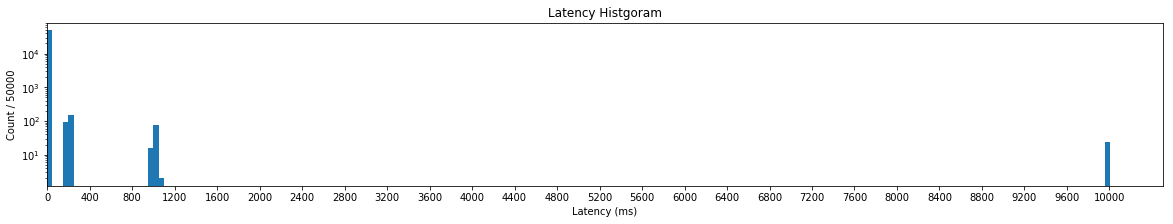

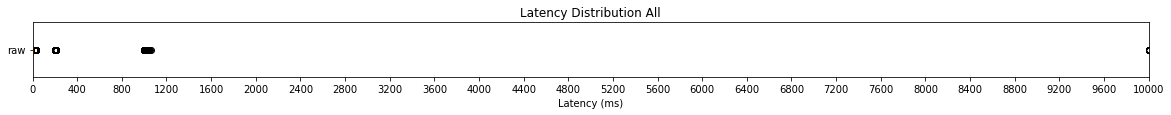

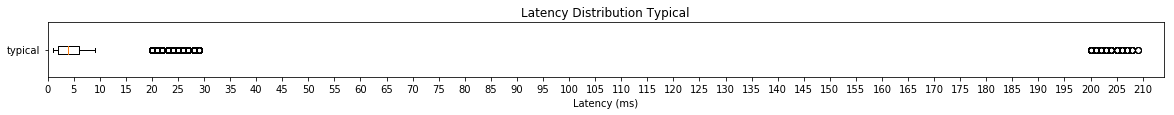

In [2]:


fig = plt.figure(None, (20, 3))
plt.title("Latency Histgoram")
plt.semilogy()
plt.ylabel("Count / {}".format(50000))
plt.xlabel("Latency (ms)")
plt.hist(data, 200)
plt.gca().set_xlim(0)
plt.xticks(np.arange(0, max(data)+1, 400))
plt.show()

fig2 = plt.figure(None, (20, 1))
plt.title("Latency Distribution All")
plt.xlabel("Latency (ms)")
plt.gca().set_xlim(0)
plt.xticks(np.arange(0, max(data)+1, 400))
plt.boxplot([data], vert=False, labels=["raw"])
plt.show()

fig3 = plt.figure(None, (20, 1))
plt.title("Latency Distribution Typical")
plt.xlabel("Latency (ms)")
plt.gca().set_xlim(0, max(typical)+5)
plt.xticks(np.arange(0, max(typical)+5, 5))
plt.boxplot([typical], vert=False, labels=["typical"])
plt.show()

In [3]:
from pprint import pprint
print("Summary Statistics:")
percentiles = [50, 75, 90, 95, 99, 99.9, 100]
summary = np.percentile(data, percentiles)
m = {
    percentiles[i] : summary[i] for i in range(len(percentiles))
}
print("{:.10}:     {:.10s}".format("Percentile", "Millis"))
for (k, v) in sorted(m.items()):
    print("{:9.2f}%: {:10.0f}".format(k, v))

Summary Statistics:
Percentile:     Millis
    50.00%:          4
    75.00%:          6
    90.00%:          9
    95.00%:         22
    99.00%:         28
    99.90%:       1013
   100.00%:      10004


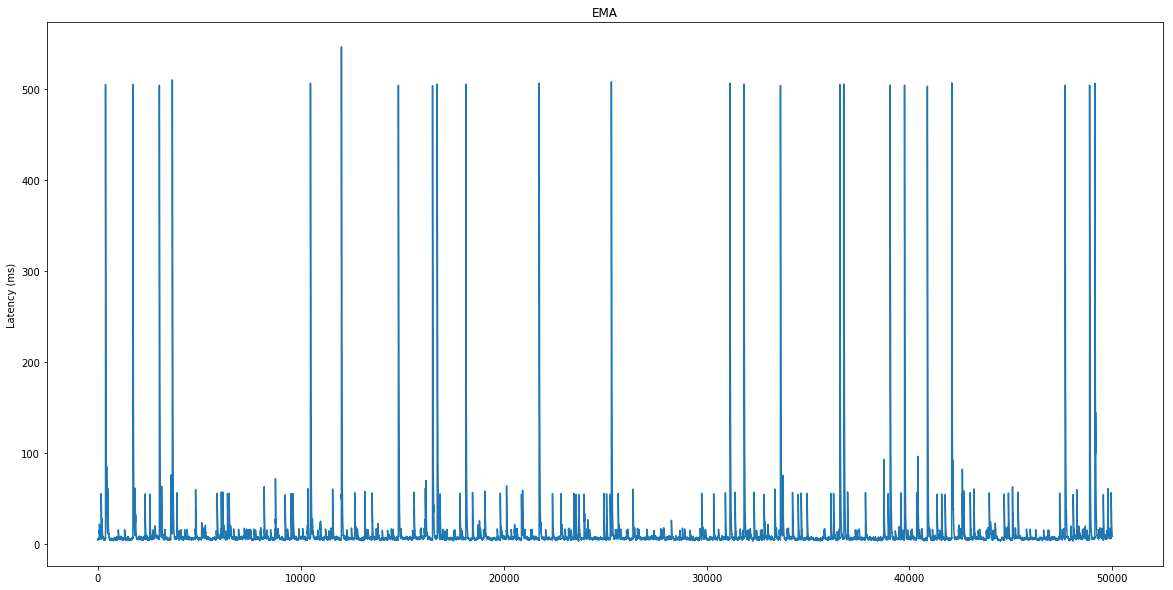

In [4]:
ema = EMA(0.05, data[0])
result = []
for d in data:
    ema.sample(d)
    result.append(ema.measure())

plt.figure(None, (20, 10))
plt.plot(result)
plt.ylabel("Latency (ms)")
plt.title('EMA')
plt.show()

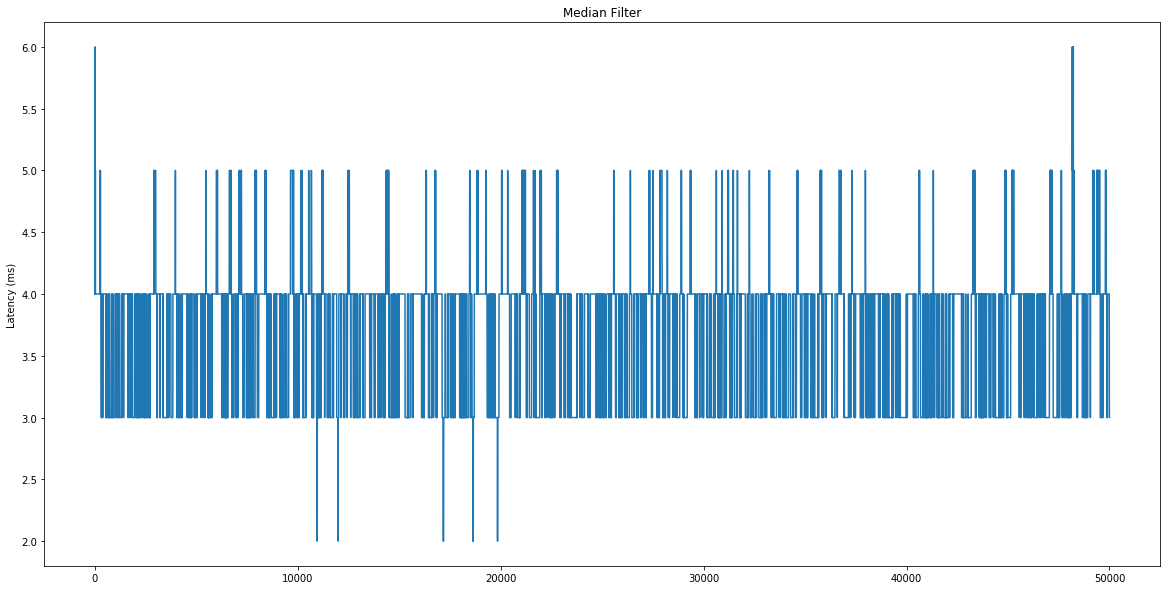

In [5]:
mf = MedianFilter(data[0], 100)
result = []
for d in data:
    mf.sample(d)
    result.append(mf.measure())
    
plt.figure(None, (20, 10))
plt.plot(result)
plt.ylabel("Latency (ms)")
plt.title('Median Filter')
plt.show()